In [282]:
import random
from copy import deepcopy
from typing import Literal
from itertools import cycle

import pandas as pd
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report,
                             roc_curve, auc, confusion_matrix, RocCurveDisplay)

In [2]:
eps = 1e-9

SEED = 18092025
random.seed(SEED)
np.random.seed(SEED)

[Датасет](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

In [3]:
try:
    df = pd.read_csv('../datasets/data.csv', delimiter=';')
except Exception:
    print('No such file')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

pd.set_option('display.expand_frame_repr', False)


# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_colwidth')
# pd.reset_option('display.width')
# pd.reset_option('display.expand_frame_repr')

---

## EDA

In [5]:
def display_nans(df):
    nans_per_col = [(col, df[col].isna().sum(), df[col].isna().sum() / df.shape[0] * 100) for col in df.columns]
    dtype = [('col_name', 'U20'), ('nans', int), ('nans_perc', float)]
    nans_per_col = np.array(nans_per_col, dtype=dtype)
    nans_per_col = nans_per_col[nans_per_col['nans'] > 0]
    nans_per_col = np.sort(nans_per_col, order='nans')

    if nans_per_col.shape[0] == 0:
        print('No nans in the dataset')
        return

    df_show = pd.DataFrame(nans_per_col[::-1])
    display(df_show.style.background_gradient(cmap='Blues'))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    y_pos = np.arange(len(nans_per_col))
    
    ax.barh(y_pos, nans_per_col['nans_perc'], alpha=0.8, edgecolor='black', linewidth=1) 
    ax.set_yticks(y_pos, labels=nans_per_col['col_name'])
    ax.set_xlabel('Nans, %', fontsize=14)
    ax.set_title('Nans rate for each column', fontsize=16)
    ax.set_xlim(0, min(np.max(df_show['nans_perc']) + 5.0, 100.0))
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(axis='x', linestyle='--', linewidth=0.5)
    
    plt.show()

In [6]:
display(df.head())
print('Dataset shape: ', df.shape)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Dataset shape:  (4424, 37)


In [7]:
def col_names_transform(col_name: str) -> str:
    res_name = col_name.strip().replace("\t", "").replace(' ', '_').lower()
    return res_name

In [8]:
df.columns = map(col_names_transform, df.columns.values)
df.columns

Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime/evening_attendance', 'previous_qualification',
       'previous_qualification_(grade)', 'nacionality',
       'mother's_qualification', 'father's_qualification',
       'mother's_occupation', 'father's_occupation', 'admission_grade',
       'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international',
       'curricular_units_1st_sem_(credited)',
       'curricular_units_1st_sem_(enrolled)',
       'curricular_units_1st_sem_(evaluations)',
       'curricular_units_1st_sem_(approved)',
       'curricular_units_1st_sem_(grade)',
       'curricular_units_1st_sem_(without_evaluations)',
       'curricular_units_2nd_sem_(credited)',
       'curricular_units_2nd_sem_(enrolled)',
       'curricular_units_2nd_sem_(evaluations)',
       'curricular_units_2nd_sem_(approved)',
       'curricular_units_2nd_s

In [9]:
df.describe()

,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,previous_qualification_(grade),nacionality,mother's_qualification,father's_qualification,mother's_occupation,father's_occupation,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_(credited),curricular_units_1st_sem_(enrolled),curricular_units_1st_sem_(evaluations),curricular_units_1st_sem_(approved),curricular_units_1st_sem_(grade),curricular_units_1st_sem_(without_evaluations),curricular_units_2nd_sem_(credited),curricular_units_2nd_sem_(enrolled),curricular_units_2nd_sem_(evaluations),curricular_units_2nd_sem_(approved),curricular_units_2nd_sem_(grade),curricular_units_2nd_sem_(without_evaluations),unemployment_rate,inflation_rate,gdp
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,10.960895,11.032324,126.978119,0.548373,0.011528,0.113698,0.880651,0.351718,0.248418,23.265145,0.024864,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,26.418253,25.263040,14.482001,0.497711,0.106760,0.317480,0.324235,0.477560,0.432144,7.587816,0.155729,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,4.000000,4.000000,117.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,5.000000,7.000000,126.100000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,9.000000,9.000000,134.800000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,194.000000,195.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [10]:
# TODO: добавить другие стат. показатели 

In [11]:
display_nans(df)

No nans in the dataset


In [12]:
df.dtypes

marital_status                                      int64
application_mode                                    int64
application_order                                   int64
course                                              int64
daytime/evening_attendance                          int64
previous_qualification                              int64
previous_qualification_(grade)                    float64
nacionality                                         int64
mother's_qualification                              int64
father's_qualification                              int64
mother's_occupation                                 int64
father's_occupation                                 int64
admission_grade                                   float64
displaced                                           int64
educational_special_needs                           int64
debtor                                              int64
tuition_fees_up_to_date                             int64
gender        

In [13]:
df['target'].value_counts(normalize=True).to_frame().T

target,Graduate,Dropout,Enrolled
proportion,0.499322,0.321203,0.179476


---

## Подготовка данных

In [14]:
X, y = df.drop(columns=['target']), df['target']
X.shape, y.shape

((4424, 36), (4424,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, shuffle=True, stratify=y_train)
y_train.shape, y_val.shape, y_test.shape

((3008,), (752,), (664,))

In [16]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_val_scaled   = std_scaler.transform(X_val)
X_test_scaled  = std_scaler.transform(X_test)
X_train_scaled[0, :5]

array([-0.29354919,  1.83469641, -0.55006105,  0.44272621,  0.34683995])

In [17]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train.values)
y_val_enc   = label_encoder.transform(y_val.values)
y_test_enc  = label_encoder.transform(y_test.values)
y_train[:5].values, y_train_enc[:5], label_encoder.classes_

(array(['Dropout', 'Dropout', 'Graduate', 'Enrolled', 'Enrolled'],
       dtype=object),
 array([0, 0, 2, 1, 1]),
 array(['Dropout', 'Enrolled', 'Graduate'], dtype=object))

---

## Модель линейной классификации

In [18]:
class RunningAverage:
    def __init__(self):
        self.value = 0.0
        self.count = 0

    def update(self, new_value):
        self.count += 1
        self.value = (1 / self.count) * new_value + (1 - 1 / self.count) * self.value
        return self.value
    

class EMA:
    def __init__(self, l=0.1):
        self.value = None
        self.l = l

    def update(self, new_value):
        if self.value is not None:
            self.value = self.l * new_value + (1 - self.l) * self.value
        else:
            self.value = new_value
        return self.value

In [187]:
class LogRegNumpy():

    def __init__(
        self,
        initial_weights: list[list[float]] = None, # (n_features, n_classes)
        initial_bias:    list[float] = None,       # (1, n_classes)
        tolerance:       float = 1e-4,
        early_stop: bool = False,
        n_startup_rounds: int = 50,
        early_stop_rounds: int = 50,
        random_seed: int = SEED
    ):
        self.weights = (np.array(initial_weights) if initial_weights is not None 
                        else np.array([]))
        self.bias = (np.array(initial_bias) if initial_bias is not None 
                     else np.array([]))
        self.tolerance = tolerance
        self.early_stop = early_stop
        self.n_startup_rounds = n_startup_rounds
        self.early_stop_rounds = early_stop_rounds
        self.random_seed = random_seed
        self.eps = 1e-9

        self.rng_ = np.random.default_rng(seed=random_seed)

        # для рекуррентной оценки
        self.rec_value = [None, None]
        self.rec_count = [0, 0]
        self.rec_history = [[], []]

    
    def fit(
        self,
        X_train, y_train,
        X_val = None, y_val = None,
        learning_rate:  float = 1e-3,
        total_steps:    int = 1000,
        batch_size:     int | None = None, # None = full dataset
        gd_algo:        Literal['gd', 'sgd'] = 'sgd',
        momentum:       float = 0.0,
        l2:             float = 0.0,
        optim_step:     bool = False,
        init_strategy:  Literal['normal', 'corr', 'multistart'] = 'normal',
        return_weights_history:  bool = False,
        verbose:                 bool = False,
        # рекуррентная оценка функции потерь
        rec_mode:                Literal['off','mean','ema'] = 'off',
        ema_lambda:              float = 0.1,
        # стратегия сэмплирования
        sampling_mode:           Literal['uniform','by_margin'] = 'uniform',
        shuffle:                 bool = True,
        sampling_tau:            float = 0.2,
        sampling_min_prob:       float = 0.01,
        refresh_rate:            int = 100,
        steps_per_epoch:         int | None = 100, # для логики логирования
    ) -> None | list[list[float]]:

        have_validation = False
        if (X_val is not None) and (y_val is not None):
            have_validation = True

        input_check = lambda data, dtype: (
            np.array(data, dtype=dtype).squeeze()
            if not isinstance(data, np.ndarray)
            else deepcopy(data).astype(dtype, copy=False)
        )
        X_train, y_train = input_check(X_train, np.float32), input_check(y_train, np.int32)
        if X_train.ndim == 1:
            X_train = X_train[np.newaxis, :]

        if have_validation:
            X_val, y_val = input_check(X_val, np.float32), input_check(y_val, np.int32)
            if X_val.ndim == 1:
                X_val = X_val[np.newaxis, :]

        N = X_train.shape[0]

        if gd_algo == 'gd':
            batch_size = None

        if batch_size is None:
            batch_size = N

        if steps_per_epoch is None:
            steps_per_epoch = (N + batch_size - 1) // batch_size

        # --- init
        self._init_weights(X_train, y_train, init_strategy)
        if return_weights_history:
            weights_values = [self.weights.copy()]
        Vdw = np.zeros_like(self.weights)
        Vdb = np.zeros_like(self.bias)
        self._rec_reset()
        self.loss_values = ([], [])
        no_improvement_counter = 0
        rng = self.rng_
            
        def uniform_next_batch_stateful():
            perm = rng.permutation(N) if shuffle else np.arange(N, dtype=np.int64)
            ptr = 0

            def get_batch():
                nonlocal perm, ptr
                if ptr >= N:
                    perm = rng.permutation(N) if shuffle else np.arange(N, dtype=np.int64)
                    ptr = 0

                remaining = N - ptr
                take = batch_size if batch_size <= remaining else remaining

                idx = perm[ptr:ptr + take]
                ptr += take
                return idx

            return get_batch

        margin_probs = lambda: self._margin_sampling_probs(
            X_train, y_train, use_abs=True, tau=sampling_tau, min_prob=sampling_min_prob
        )

        # ---- training loop (one unified path)
        step = 0
        block_loss_sum = 0.0
        block_count = 0

        if sampling_mode == 'uniform':
            next_uniform_batch = uniform_next_batch_stateful()
        elif sampling_mode == 'by_margin':
            probs = margin_probs()
            next_uniform_batch = None
        else:
            raise ValueError("sampling_mode must be 'uniform' or 'by_margin'")

        # init validation score
        self._run_validation(X_train, y_train, rec_mode, ema_lambda, 0)
        if have_validation:
            self._run_validation(X_val, y_val, rec_mode, ema_lambda)

        while step < total_steps:
            if sampling_mode == 'uniform':
                batch_idx = next_uniform_batch()
            else:  # by_margin
                if step % refresh_rate == 0:
                    probs = margin_probs()
                batch_idx = rng.choice(N, size=batch_size, replace=True, p=probs)

            xi = X_train[batch_idx, :]
            yi = y_train[batch_idx]

            # forward / loss
            logits = self.forward(xi)
            loss   = self._loss_fn_opt(yi, logits, reduction=None)

            # Self-Normalized Importance Sampling Loss
            if sampling_mode == 'by_margin':
                pi = probs[batch_idx]
                sample_weights = 1.0 / np.clip(pi, 1e-12, None)
                loss = (loss * sample_weights).sum() / sample_weights.sum()
            else:
                sample_weights = None
                loss = loss.mean()
                
            block_loss_sum += loss
            block_count    += 1

            # recurrent quality update (train loss)
            train_rec_val = self._rec_update(loss, mode=rec_mode, set_id=0, ema_lambda=ema_lambda)
            self.rec_history[0].append(train_rec_val)

            # gradients
            w_grad, b_grad = self._gradient(xi, yi, logits)
            # L2 - regularization
            if l2 > 0.0:
                w_grad += l2 * self.weights

            # momentum (EMA style)
            Vdw = momentum * Vdw - (1.0 - momentum) * w_grad
            Vdb = momentum * Vdb - (1.0 - momentum) * b_grad
            
            if optim_step:
                learning_rate = self._line_search_backtracking(
                    xi, yi, w_grad, b_grad, Vdw, Vdb, l2=l2
                )

            # update
            self.weights += learning_rate * Vdw
            self.bias    += learning_rate * Vdb

            step += 1

            # logging once per “epoch-sized” number of steps
            if block_count >= steps_per_epoch:
                mean_block_loss = block_loss_sum / block_count
                self.loss_values[0].append(mean_block_loss)

                # validation
                if have_validation:
                    self._run_validation(X_val, y_val, rec_mode, ema_lambda)

                # # recurrent quality update
                # rec_val = self._rec_update(mean_block_loss, mode=rec_mode, ema_lambda=ema_lambda)
                # self.rec_history.append(rec_val)

                if return_weights_history:
                    weights_values.append(self.weights.copy())
                if verbose:
                    print(f"step {step:6d} | block_loss={mean_block_loss:.6f} | batch_size={batch_size} | mode={sampling_mode}")

                block_loss_sum = 0.0
                block_count = 0

            # early stopping on monitored series (smoothed if rec_mode != 'off'), done on training set,
            # recalculating loss on validation each opt. step is too costly
            if self.early_stop and step > self.n_startup_rounds + 1:
                if 0 < (self.rec_history[0][-2] - self.rec_history[0][-1]) < self.tolerance:
                    no_improvement_counter += 1
                    if no_improvement_counter >= self.early_stop_rounds:
                        if verbose:
                            print(f"Early stopping at step {step}")
                        break
                else:
                    no_improvement_counter = 0

        if return_weights_history:
            return np.array(weights_values)
        
        return
        
        
    def _line_search_backtracking(
        self,
        X, y, 
        grad_w: np.ndarray, grad_b: np.ndarray, 
        dir_w:  np.ndarray, dir_b:  np.ndarray,
        step: float = 1.0, 
        alpha: float = 1e-4, 
        beta: float = 0.5, 
        tol: float = 1e-8,
        l2: float = 0.0,
        default_lr: float = 1e-9,
        eps: float = 1e-12
    ):
        logits_0 = self.forward(X)
        loss_0 = self._loss_fn_opt(y, logits_0, reduction='mean')
        if l2 > 0.0:
            loss_0 += l2 * np.sum(np.pow(self.weights, 2)) * 0.5
        
        W0 = self.weights
        b0 = self.bias

        # directional derivatives
        dw = (grad_w * dir_w).sum()
        db = (grad_b * dir_b).sum()
        dd = dw + db
        
        if l2 > 0.0:
            dd += l2 * (W0 * dir_w).sum()

        if dd >= eps:
            if np.allclose(dir_w, -grad_w) and np.allclose(dir_b, -grad_b):
                return 0.0
            # switching to regular gradient descent
            np.copyto(dst=dir_w, src=-grad_w); np.copyto(dst=dir_b, src=-grad_b)
            dd = (grad_w * dir_w).sum() + (grad_b * dir_b).sum()
            if l2 > 0.0:
                dd += l2 * (W0 * dir_w).sum()
            if dd >= eps:
                return 0.0

        t = step

        # TODO: добавить оптимизации через раскрытие logits_t и l2_norm и предварительного подсчета неизменных членов
        while t > tol:
            Wt = W0 + t * dir_w
            bt = b0 + t * dir_b
            logits_t = np.matmul(X, Wt) + bt
            loss_t = self._loss_fn_opt(y, logits_t, reduction='mean')
            if l2 > 0.0:
                loss_t += l2 * np.sum(np.pow(Wt, 2)) * 0.5

            if loss_t <= loss_0 + alpha * t * dd:
                return t
            
            t *= beta

        return default_lr
    
    def _run_validation(self, X, y, rec_mode, ema_lambda, set_id=1):
        logits_valid = self.forward(X)
        loss_valid = self._loss_fn_opt(y, logits_valid, reduction='mean')
        self.loss_values[set_id].append(loss_valid)
        valid_rec_val = self._rec_update(loss_valid, mode=rec_mode, set_id=1, ema_lambda=ema_lambda)
        self.rec_history[set_id].append(valid_rec_val)


    def predict(self, features: list[list[float]]):
        X = (np.array(features).squeeze() if not isinstance(features, np.ndarray) 
             else deepcopy(features).astype(np.float32, copy=False))
        if X.ndim == 1:
            X = X[np.newaxis, :]
        logits = self.forward(X) # (n_samples, n_classes)
        probs  = self._softmax(logits) # не обязательно
        return np.argmax(probs, axis=1)

    def predict_proba(self, features: list[list[float]]):
        X = (np.array(features).squeeze() if not isinstance(features, np.ndarray) 
             else deepcopy(features).astype(np.float32, copy=False))
        if X.ndim == 1:
            X = X[np.newaxis, :]
        logits = self.forward(X) # (n_samples, n_classes)
        probs  = self._softmax(logits) # не обязательно
        return probs
    
    def _create_onehot_target(self, y: np.array):
        ohe_enc = OneHotEncoder(categories=[np.unique(y)], sparse_output=False)
        y_enc = ohe_enc.fit_transform(y.reshape(-1, 1))
        return y_enc # output -> (n_samples, n_classes)
    
    def _init_weights(
        self, X: np.ndarray, y: np.ndarray,
        init_strategy: Literal['normal', 'corr', 'multistart'] = 'normal',
        n_starts: int = 5, search_steps: int = 50, lr: float = 1e-2,
    ):
        N, d = X.shape
        K = np.max(y) + 1

        if init_strategy == 'normal':
            if self.weights.size == 0:
                self.weights = self.rng_.standard_normal((d, K), dtype=np.float32)
            if self.bias.size == 0:
                self.bias = self.rng_.standard_normal((1, K), dtype=np.float32)
            return

        if init_strategy == 'corr':
            if self.weights.size != 0 and self.bias.size != 0:
                return
            # евклидова норма
            # denom = np.sum(X * X, axis=0)       # shape (d,)
            denom = np.float64(N)

            W = np.zeros((d, K), dtype=np.float64)
            b = np.zeros((1, K), dtype=np.float64)

            for k in range(K):
                t = (y == k).astype(np.float64) # 1 for class k, else 0
                # weights: elementwise division by per-feature squared norm
                # With centered X, X^T t == X^T (t - mean(t)), so no need to center t explicitly.
                numer = X.T @ t                           # shape (d,)
                W[:, k] = numer / denom

                # intercept: with centered features, LS gives b_k = mean(t^{(k)})
                b[0, k] = t.mean()

            if self.weights.size == 0:
                self.weights = W.astype(np.float32, copy=False)
            if self.bias.size == 0:
                self.bias = b.astype(np.float32, copy=False)
            return
        
        if init_strategy == 'multistart':
            best_loss = np.inf
            best_W, best_b = None, None

            for _ in range(n_starts):
                W = self.rng_.standard_normal((d, K), dtype=np.float32)
                b = self.rng_.standard_normal((1, K), dtype=np.float32)
                
                # short warmup
                w, b, loss = self._warmup(X, y, W, b, steps=search_steps, lr=lr)
                if loss < best_loss:
                    best_loss = loss
                    best_W, best_b = w, b

                self.weights = best_W
                self.bias    = best_b
            return
        
        raise ValueError("init_strategy must be 'normal' or 'corr'")
    
    def _warmup(self, X, y, W, b, steps=50, lr=1e-2):
        W = W.copy(); b = b.copy()
        for _ in range(steps):
            logits = np.matmul(X, W) + b
            loss   = self._loss_fn_opt(y, logits, reduction='mean')
            w_grad, b_grad = self._gradient(X, y, logits)
            W -= lr * w_grad
            b -= lr * b_grad
        return W, b, float(loss)
    
        
    def _softmax(self, X: np.array) -> np.array:
        Z = X - np.max(X, axis=1, keepdims=True)
        numerator = np.exp(Z)
        denominator = np.sum(numerator, axis=1, keepdims=True)
        softmax_probs = numerator / denominator
        return softmax_probs # -> (n_samples, n_classes)
    
    def forward(self, X):
        # (n_samples, n_features) * (n_features, n_classes)
        logits = np.matmul(X, self.weights) + self.bias # -> (n_samples, n_classes)
        return logits
    
    # def loss_fn_expanded(self, X, y_true):
    #     # (n_samples, n_features) * (n_features, n_classes) + (n_samples, 1) * (1, n_classes) = (n_samples, n_classes)
    #     logits = np.matmul(X, self.weights) + np.matmul(np.ones((X.shape[0], 1)), self.bias)
    #     exp_logits = np.exp(logits)
    #     logits_sum = np.sum(exp_logits, axis=1) # -> (n_samples, 1)
    #     # (n_samples, n_classes) * (n_samples, n_classes)
    #     true_class_logits = logits[np.arange(X.shape[0]), y_true]
    #     return np.mean(np.log(logits_sum) - true_class_logits)

    # def loss_fn(self, y_true, logits):
    #     log_probs = np.log(self.softmax(logits)) # -> (n_samples, classes)
    #     # y_true_ohe = self.create_onehot_target(y_true) # -> (n_samples, classes)
    #     # likelihood = (log_probs * y_true_ohe).sum(axis=1).mean()
    #     likelihood = (log_probs[np.arange(log_probs.shape[0]), y_true]).mean()
    #     return -likelihood
    
    def _loss_fn_opt(self, y_true, logits, reduction=None):
        lse = logsumexp(logits, axis=1, keepdims=True)
        nll = lse - logits
        loss = nll[np.arange(nll.shape[0]), y_true]
        if reduction == 'mean':
            loss = loss.mean()
        return loss
    
    def _rec_reset(self):
        self.rec_value = [None, None]
        self.rec_count = [0, 0]
        self.rec_history = [[], []]

    def _rec_update(self, xi, mode="off", set_id=0, ema_lambda=0.1):
        if mode == "off":
            return xi

        if self.rec_value[set_id] is None:
            # инициализация последовательности
            self.rec_value[set_id] = xi
            self.rec_count[set_id] = 1
            return self.rec_value[set_id]

        if mode == "mean":
            # running mean: Q_m = (1/m)*xi_m + (1 - 1/m)*Q_{m-1}
            self.rec_count[set_id] += 1
            m = self.rec_count[set_id]
            self.rec_value[set_id] = (1.0 / m) * xi + (1.0 - 1.0 / m) * self.rec_value[set_id]
            return self.rec_value[set_id]

        if mode == "ema":
            # EMA: Q_m = λ xi_m + (1 - λ) Q_{m-1}
            self.rec_value[set_id] = ema_lambda * xi + (1.0 - ema_lambda) * self.rec_value[set_id]
            return self.rec_value[set_id]

        return xi

    def _gradient(self, X, y_true, logits):
        y_prob = self._softmax(logits)
        y_prob[np.arange(y_prob.shape[0]), y_true] -= 1
        y_prob /= y_prob.shape[0]
        w_grad = np.matmul(X.T, y_prob)
        b_grad = y_prob.sum(axis=0, keepdims=True)
        return w_grad, b_grad
    

    def calc_margins(self, X, y_true, plot: bool = False, eps=1e-3, **kwargs):
        logits = self.forward(X)
        true_logits = logits[np.arange(X.shape[0]), y_true]
        logits[np.arange(logits.shape[0]), y_true] = -np.inf
        false_logits = logits.max(axis=1)
        margins = true_logits - false_logits

        if plot:
            
            sorted_idx = np.argsort(margins)
            sorted_margins = margins[sorted_idx]
            
            line_kwargs      = {'lw': 2}
            pos_fill_kwargs  = {'alpha': 0.25, 'color': 'tab:green'}
            neg_fill_kwargs  = {'alpha': 0.25, 'color': 'tab:red'}
            zero_fill_kwargs = {'alpha': 0.25, 'color': 'gold'}

            # masks
            if eps > 0.0:
                mask_zero = np.abs(sorted_margins) <= eps
                mask_pos  = sorted_margins >  eps
                mask_neg  = sorted_margins < -eps
            else:
                mask_zero = np.zeros_like(sorted_margins, dtype=bool)
                mask_pos  = sorted_margins > 0
                mask_neg  = sorted_margins < 0

            plt.figure(figsize=(12, 7))
            # line
            plot_idx = np.arange(sorted_margins.shape[0])
            plt.plot(plot_idx, sorted_margins, **line_kwargs)
            plt.axhline(0.0, color='black', lw=1, alpha=0.7)

            if np.any(mask_neg):
                plt.fill_between(plot_idx, sorted_margins, 0.0, where=mask_neg, interpolate=True, **neg_fill_kwargs)
            if np.any(mask_zero):
                plt.fill_between(plot_idx, sorted_margins, 0.0, where=mask_zero, interpolate=True, **zero_fill_kwargs)
            if np.any(mask_pos):
                plt.fill_between(plot_idx, sorted_margins, 0.0, where=mask_pos, interpolate=True, **pos_fill_kwargs)

            plt.xlabel("sample index (sorted)")
            plt.ylabel("margin")
            plt.title("Margin curve with signed areas")
            plt.tight_layout()
            plt.show()

        return margins
    
    # TODO: сделать сэмплер с разной логикой выбора сложных случаев
    # 1) -abs(margins) - для любых (правильных или нет) случаев с малой долей уверенности
    # 2) -margins вместо -abs(margins) - для точно неправильно классифицированных случаев
    def _margin_sampling_probs(
        self, X, y, use_abs: bool = True, tau: float = 0.2, min_prob: float = 0.01
    ):
        margins = self.calc_margins(X, y)

        diff = -np.abs(margins) if use_abs else -margins
        scores = diff / max(tau, 1e-8)
        probs = self._softmax(scores.reshape(1, -1)).squeeze()

        floor = min_prob / X.shape[0]
        probs = (1.0 - min_prob) * probs + floor

        return probs

In [191]:
logreg = LogRegNumpy(early_stop=True)
# logreg._init_weights(X_train_scaled, y_train_enc, 'multistart')

In [192]:
logreg.fit(
    X_train_scaled, y_train_enc, X_val_scaled, y_val_enc,
    learning_rate=5e-3, total_steps=X_train_scaled.shape[0]*3, init_strategy='normal',
    batch_size=64, momentum=0.99, l2=0.01, optim_step=False, verbose=True, rec_mode='ema', ema_lambda=0.01,
    sampling_mode='by_margin', shuffle=True, sampling_tau=0.5, sampling_min_prob=0.01, refresh_rate=200,
    steps_per_epoch=100
)

step    100 | block_loss=4.030042 | batch_size=64 | mode=by_margin
step    200 | block_loss=3.820268 | batch_size=64 | mode=by_margin
step    300 | block_loss=3.199123 | batch_size=64 | mode=by_margin
step    400 | block_loss=3.085672 | batch_size=64 | mode=by_margin
step    500 | block_loss=2.946899 | batch_size=64 | mode=by_margin
step    600 | block_loss=2.993919 | batch_size=64 | mode=by_margin
step    700 | block_loss=3.047401 | batch_size=64 | mode=by_margin
step    800 | block_loss=2.716946 | batch_size=64 | mode=by_margin
step    900 | block_loss=2.625340 | batch_size=64 | mode=by_margin
step   1000 | block_loss=2.569660 | batch_size=64 | mode=by_margin
step   1100 | block_loss=2.977454 | batch_size=64 | mode=by_margin
step   1200 | block_loss=1.596273 | batch_size=64 | mode=by_margin
step   1300 | block_loss=1.886349 | batch_size=64 | mode=by_margin
step   1400 | block_loss=2.126791 | batch_size=64 | mode=by_margin
step   1500 | block_loss=2.193053 | batch_size=64 | mode=by_ma

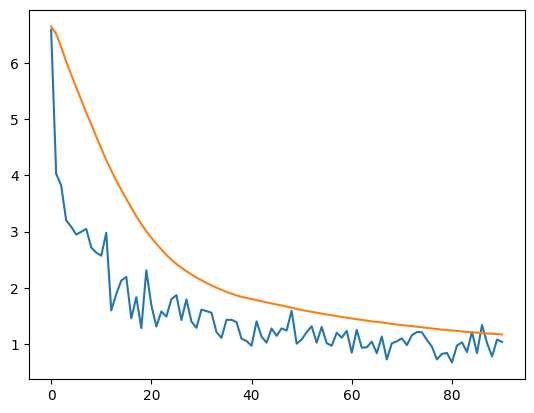

In [193]:
plt.plot(logreg.loss_values[0])
plt.plot(logreg.loss_values[1])
plt.show()

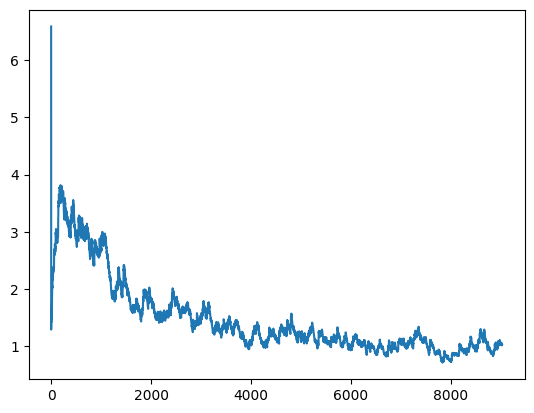

In [199]:
plt.plot(logreg.rec_history[0])
plt.show()

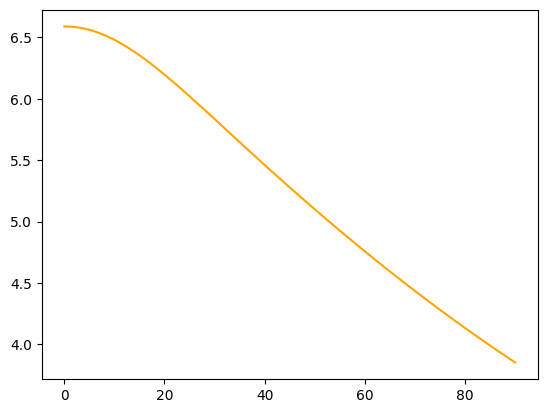

In [200]:
plt.plot(logreg.rec_history[1], color='orange')
plt.show()

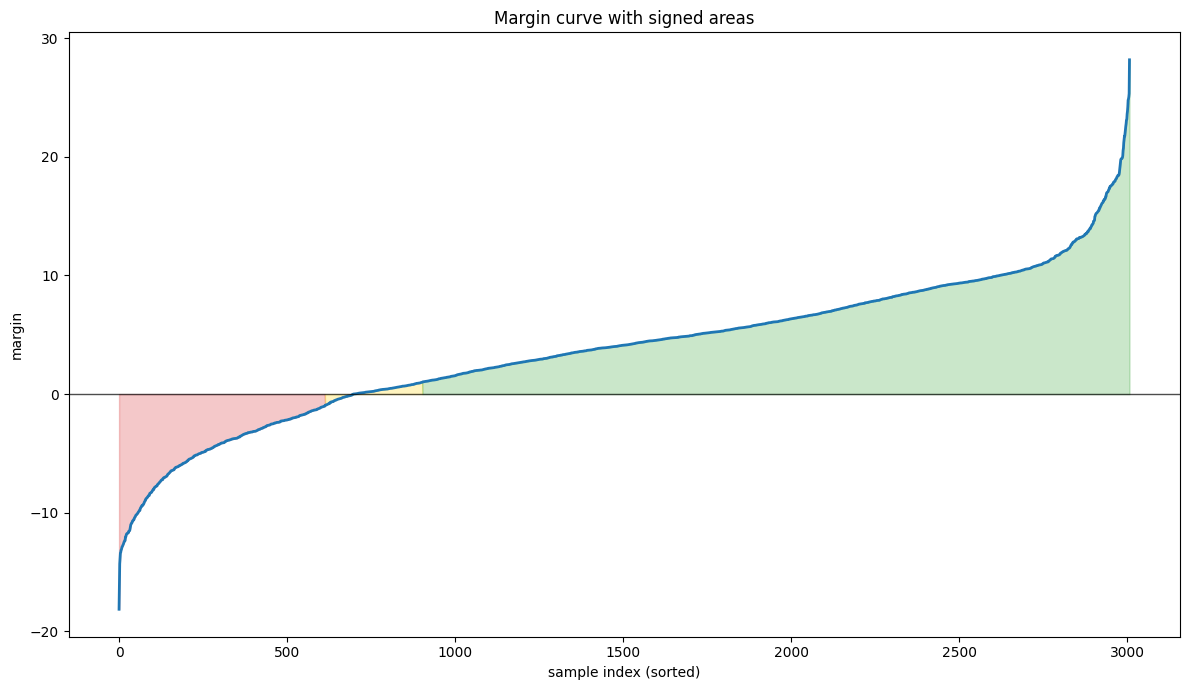

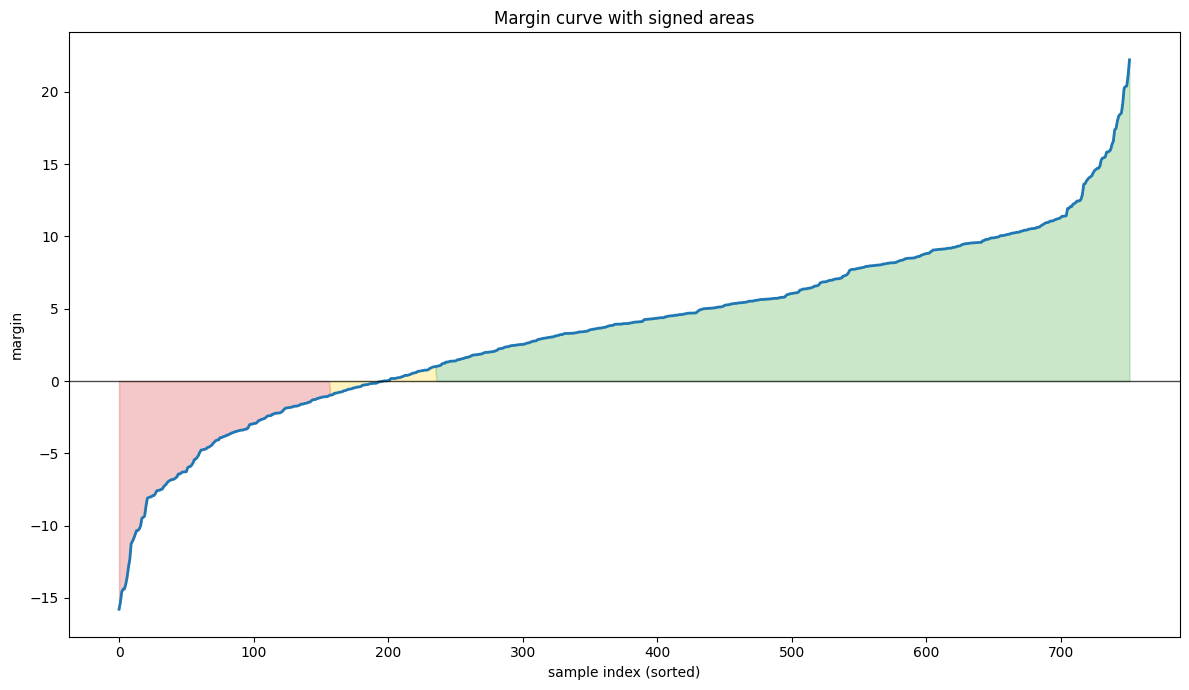

In [201]:
margins_train = logreg.calc_margins(X_train_scaled, y_train_enc, plot=True, eps=1.0)
margins_val   = logreg.calc_margins(X_val_scaled, y_val_enc, plot=True, eps=1.0)

In [202]:
preds_train = logreg.predict(X_train_scaled)
preds_val   = logreg.predict(X_val_scaled)
preds_test  = logreg.predict(X_test_scaled)

In [203]:
print(f'Train accuracy: {(preds_train == y_train_enc).mean()*100.:.4f}')
print(f'Validation accuracy: {(preds_val == y_val_enc).mean()*100.:.4f}')
print(f'Test accuracy: {(preds_test == y_test_enc).mean()*100.:.4f}')

Train accuracy: 76.8285
Validation accuracy: 73.8032
Test accuracy: 71.5361


In [291]:
# ---- your existing helpers kept as-is ----
def _ensure_class_names(y_true, y_pred, class_names):
    if class_names is None:
        classes = sorted(list(set(np.asarray(y_true).tolist()) | set(np.asarray(y_pred).tolist())))
        class_names = [str(c) for c in classes]
        labels = classes
    else:
        labels = class_names if not np.issubdtype(np.asarray(y_true).dtype, np.integer) else list(range(len(class_names)))
    return class_names, labels

def plot_multiclass_confusion_matrix(
    y_true, y_pred, class_names=None, normalize=True, cmap="Blues", figsize=(10,8), annot=True, title=None
):
    class_names, labels = _ensure_class_names(y_true, y_pred, class_names)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if normalize:
        with np.errstate(invalid="ignore", divide="ignore"):
            cm = cm / cm.sum(axis=1, keepdims=True)
        fmt, cbar_label = ".2f", "Proportion"
    else:
        fmt, cbar_label = "d", "Count"

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm, annot=annot, fmt=fmt, cmap=cmap,
                     xticklabels=class_names, yticklabels=class_names,
                     linewidths=.5, linecolor="white", cbar_kws={"label": cbar_label})
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title or ("Confusion Matrix (row-normalized)" if normalize else "Confusion Matrix"))
    plt.tight_layout()
    plt.show()

def per_class_tp_fp_fn_tn_table(y_true, y_pred, class_names=None):
    class_names, labels = _ensure_class_names(y_true, y_pred, class_names)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    return pd.DataFrame({"TP": tp, "FP": fp, "FN": fn, "TN": tn}, index=class_names)

def plot_tp_fp_fn_tn_table(y_true, y_pred, class_names=None, cmap="YlGnBu", figsize=(6,1.2), title=None):
    df = per_class_tp_fp_fn_tn_table(y_true, y_pred, class_names)
    plt.figure(figsize=(figsize[0], figsize[1] * len(df)))
    ax = sns.heatmap(df, annot=True, fmt="d", cmap=cmap, cbar=False,
                     linewidths=.5, linecolor="white")
    ax.set_xlabel("Metric")
    ax.set_ylabel("Class")
    ax.set_title(title or "Per-class TP / FP / FN / TN")
    plt.tight_layout()
    plt.show()

# ----------------- model adapters you already had -----------------
def _try_fit(model, Xtr, ytr, fit_args, Xval=None, yval=None):
    try:
        return model.fit(Xtr, ytr, **(fit_args or {}))
    except TypeError:
        val_set = (Xval, yval) if (Xval is not None and yval is not None) else (None, None)
        return model.fit((Xtr, ytr), val_set, **(fit_args or {}))

def _proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    df = model.decision_function(X)
    if df.ndim == 1:
        df = np.c_[-df, df]
    e = np.exp(df - df.max(axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

# ----------------- New pretty table utilities -----------------
# ----------------- New pretty table utilities (alignment-fixed, ASCII fallback) -----------------

def _print_cv_tables(cv_df: pd.DataFrame):
    # keep a consistent index name
    cv_df = cv_df.copy()
    cv_df.index.name = cv_df.index.name or "fold"

    mean_df = cv_df.mean(axis=0).to_frame().T
    mean_df.index = ["mean"]
    mean_df.index.name = cv_df.index.name

    _print_box_table(cv_df, title="Cross-Validation (per-fold)", index_name=cv_df.index.name, ascii_borders=True)
    _print_box_table(mean_df, title="Cross-Validation (mean across folds)", index_name=cv_df.index.name, ascii_borders=True)


def _print_box_table(
    df: pd.DataFrame,
    title=None,
    digits=4,
    split_after_rows=None,
    index_name=None,
    ascii_borders=False,   # <- toggle if your console mis-renders box characters
):
    """
    Pretty box table with:
      - numeric headers & values right-aligned
      - index header & values left-aligned
      - robust width calculation
      - optional ASCII borders if Unicode box-drawing looks misaligned
    """
    if title:
        print("\n" + title)
        print("-" * len(title))

    # choose border chars
    if ascii_borders:
        TL, TM, TR = "+", "+", "+"
        ML, MM, MR = "+", "+", "+"
        BL, BM, BR = "+", "+", "+"
        V = "|"
        H = "-"
    else:
        TL, TM, TR = "┌", "┬", "┐"
        ML, MM, MR = "├", "┼", "┤"
        BL, BM, BR = "└", "┴", "┘"
        V = "│"
        H = "─"

    def _is_num(x):
        return isinstance(x, (int, np.integer, float, np.floating)) or (isinstance(x, str) and x.replace(".","",1).isdigit())

    def _fmt_cell(x):
        if isinstance(x, (float, np.floating)):
            return f"{x:.{digits}f}"
        if isinstance(x, (int, np.integer)):
            return str(int(x))
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return ""
        return str(x)

    # copy as object so we fully control string formatting
    df = df.copy()
    df = df.astype(object)

    # per-column "numericness": treat a column numeric if ALL non-blank entries are numeric
    is_num_col = {}
    for c in df.columns:
        col = df[c].map(lambda v: (v is None) or (isinstance(v, float) and np.isnan(v)) or _is_num(v))
        is_num_col[c] = bool(col.all())

    # stringify data for width calc
    data_str = df.map(_fmt_cell)

    # compute widths (header vs content)
    col_widths = {}
    for c in df.columns:
        header = str(c)
        body_w = 0 if data_str.empty else data_str[c].map(len).max()
        col_widths[c] = max(len(header), body_w)

    idx_name = index_name if index_name is not None else (df.index.name or "")
    idx_vals = df.index.astype(str)
    idx_width = max(len(str(idx_name)), (0 if df.index.empty else idx_vals.map(len).max()))

    def _hseg(left, mid, right):
        # each cell prints as " {content:<w} " or " {content:>w} " so add 2
        return left + H * (idx_width + 2) + "".join(
            mid + H * (col_widths[c] + 2) for c in df.columns
        ) + right

    top    = _hseg(TL, TM, TR)
    mid    = _hseg(ML, MM, MR)
    bottom = _hseg(BL, BM, BR)

    # header: index left; numeric headers right; text headers left
    hdr_idx = f"{idx_name:<{idx_width}}"
    hdr_cells = []
    for c in df.columns:
        h = str(c)
        if is_num_col[c]:
            hdr_cells.append(f"{h:>{col_widths[c]}}")
        else:
            hdr_cells.append(f"{h:<{col_widths[c]}}")
    hdr_line = f"{V} {hdr_idx} {V}" + f"{V}".join(f" {h} " for h in hdr_cells) + f"{V}"

    print(top)
    print(hdr_line)
    print(mid)

    split_after = set(split_after_rows or [])
    for i, (idx, row) in enumerate(df.iterrows()):
        idx_cell = f"{str(idx):<{idx_width}}"
        body_cells = []
        for c in df.columns:
            s = _fmt_cell(row[c])
            if is_num_col[c] and s != "":
                body_cells.append(f"{s:>{col_widths[c]}}")
            else:
                body_cells.append(f"{s:<{col_widths[c]}}")
        line = f"{V} {idx_cell} {V}" + f"{V}".join(f" {cell} " for cell in body_cells) + f"{V}"
        print(line)
        if i in split_after and i != len(df) - 1:
            print(mid)

    print(bottom)
    print()


def _print_pretty_classification_report(
    y_true, y_pred, class_names=None, digits=4,
    title="Classification Report (test set)", ascii_borders=True
):
    rep = classification_report(y_true, y_pred, target_names=class_names,
                                output_dict=True, zero_division=0)
    order_cols = ["precision", "recall", "f1-score", "support"]

    # class rows
    class_labels = class_names if class_names is not None else [
        k for k in rep.keys() if k not in ("accuracy", "macro avg", "weighted avg")
    ]
    df_classes = pd.DataFrame(
        [[rep[l].get(c, "") for c in order_cols] for l in class_labels],
        index=class_labels, columns=order_cols
    )

    # --- FIXED: use empty strings instead of None/NaN in the accuracy row ---
    total_support = int(sum(rep[l]["support"] for l in class_labels))
    acc_row = pd.DataFrame(
        [{"precision": "", "recall": "", "f1-score": rep["accuracy"], "support": total_support}],
        index=["accuracy"]
    )

    df_macro    = pd.DataFrame([[rep["macro avg"][c]    for c in order_cols]], index=["macro avg"],    columns=order_cols)
    df_weighted = pd.DataFrame([[rep["weighted avg"][c] for c in order_cols]], index=["weighted avg"], columns=order_cols)

    df = pd.concat([df_classes, acc_row, df_macro, df_weighted], axis=0)

    # draw a horizontal rule after per-class rows
    split_after = [len(df_classes) - 1]
    _print_box_table(df, title=title, digits=digits, split_after_rows=split_after, ascii_borders=ascii_borders)


def plot_roc_ovr_sklearn_style(y_train, y_test, y_proba, class_names=None,
                               fig_kw=dict(figsize=(6, 6)),
                               title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass"):
    """
    Plot OvR ROC curves with the same look & feel as the scikit-learn example:
    - per-class curves via RocCurveDisplay (aqua/darkorange/cornflowerblue cycling)
    - micro-average: deeppink, dotted, lw=4
    - macro-average: navy, dotted, lw=4
    - chance level dashed black
    """
    # Binarize
    lb = LabelBinarizer().fit(y_train)
    y_onehot_test = lb.transform(y_test)
    if y_onehot_test.shape[1] == 1:
        # binary edge case -> make it 2 columns
        y_onehot_test = np.c_[1 - y_onehot_test, y_onehot_test]

    n_classes = y_onehot_test.shape[1]
    if class_names is None:
        class_names = [f"class {i}" for i in range(n_classes)]

    # Per-class ROC (to compute macro later)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # ---- Plot (sklearn style) ----
    fig, ax = plt.subplots(**fig_kw)

    # micro
    ax.plot(
        fpr["micro"], tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink", linestyle=":", linewidth=4,
    )

    # macro
    ax.plot(
        fpr["macro"], tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy", linestyle=":", linewidth=4,
    )

    # per-class curves via RocCurveDisplay (cycle colors as in the example)
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_proba[:, class_id],
            name=f"ROC curve for {class_names[class_id]}",
            ax=ax,
            plot_chance_level=(class_id == n_classes - 1),  # dashed black diagonal once
            despine=True,
            **dict(color=color, linewidth=2)
        )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title,
        # xlim=(0.0, 1.0),
        # ylim=(0.0, 1.05),
    )
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    return ax

# ----------------- One-model benchmark (same interface) -----------------

def benchmark_classifier(
    model_cls,
    X_train, y_train,
    X_test,  y_test,
    *,
    cv_folds=5,
    model_args=None,
    fit_args=None,
    random_state=42,
    class_names=None,
    plot_roc=True,
    plot_confusions=True
):
    model_args = model_args or {}
    fit_args   = fit_args   or {}

    # ===== 1) Stratified CV on train =====
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    per_fold = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), start=1):
        Xtr, Xva = X_train[tr_idx], X_train[va_idx]
        ytr, yva = y_train[tr_idx], y_train[va_idx]

        model = model_cls(**model_args)
        _try_fit(model, Xtr, ytr, fit_args, Xval=Xva, yval=yva)

        yhat = model.predict(Xva)

        acc  = accuracy_score(yva, yhat)
        p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(yva, yhat, average="micro", zero_division=0)
        p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(yva, yhat, average="macro", zero_division=0)
        p_w, r_w, f_w, _             = precision_recall_fscore_support(yva, yhat, average="weighted", zero_division=0)

        per_fold.append(dict(
            fold=fold,
            accuracy=acc,
            precision_micro=p_micro, recall_micro=r_micro, f1_micro=f_micro,
            precision_macro=p_macro, recall_macro=r_macro, f1_macro=f_macro,
            precision_weighted=p_w, recall_weighted=r_w, f1_weighted=f_w
        ))

    cv_df = pd.DataFrame(per_fold).set_index("fold")
    _print_cv_tables(cv_df)

    # ===== 2) Fit on full train, evaluate on test =====
    final_model = model_cls(**model_args)
    _try_fit(final_model, X_train, y_train, fit_args)

    y_pred  = final_model.predict(X_test)
    y_proba = _proba(final_model, X_test)

    _print_pretty_classification_report(y_test, y_pred, class_names=class_names, digits=4)

    # ===== 3) Plots (ROC + Confusions) =====
    if plot_roc:
        plot_roc_ovr_sklearn_style(y_train, y_test, y_proba, class_names=class_names)

    if plot_confusions:
        plot_multiclass_confusion_matrix(
            y_test, y_pred, class_names=class_names, normalize=True,
            title="Confusion Matrix (test, row-normalized)"
        )
        plot_tp_fp_fn_tn_table(
            y_test, y_pred, class_names=class_names,
            title="Per-class TP/FP/FN/TN (test)"
        )

    # Pack results (unchanged interface)
    results = {
        "cv_per_fold": cv_df,
        "cv_mean": cv_df.mean(axis=0).to_frame().T,  # DataFrame with one "mean" row
        "y_test": y_test,
        "y_pred": y_pred
    }
    return final_model, results

In [292]:
X_trainval = np.r_[X_train_scaled, X_val_scaled]
y_trainval = np.r_[y_train_enc, y_val_enc]

In [293]:
model_args = dict(
    early_stop=True
)

fit_args = dict(
    learning_rate=1e-2, total_steps=X_train_scaled.shape[0]*3, init_strategy='normal',
    batch_size=1, momentum=0.99, l2=0.01, optim_step=False, verbose=False, rec_mode='ema', ema_lambda=0.01,
    sampling_mode='uniform', shuffle=True, sampling_tau=0.5, sampling_min_prob=0.01, refresh_rate=200,
    steps_per_epoch=100
)


Cross-Validation (per-fold)
---------------------------
+------+----------+-----------------+--------------+----------+-----------------+--------------+----------+--------------------+-----------------+-------------+
| fold | accuracy | precision_micro | recall_micro | f1_micro | precision_macro | recall_macro | f1_macro | precision_weighted | recall_weighted | f1_weighted |
+------+----------+-----------------+--------------+----------+-----------------+--------------+----------+--------------------+-----------------+-------------+
| 1    |   0.7540 |          0.7540 |       0.7540 |   0.7540 |          0.6968 |       0.6579 |   0.6680 |             0.7403 |          0.7540 |      0.7390 |
| 2    |   0.7660 |          0.7660 |       0.7660 |   0.7660 |          0.7200 |       0.6677 |   0.6808 |             0.7553 |          0.7660 |      0.7493 |
| 3    |   0.7646 |          0.7646 |       0.7646 |   0.7646 |          0.6982 |       0.6831 |   0.6886 |             0.7547 |          

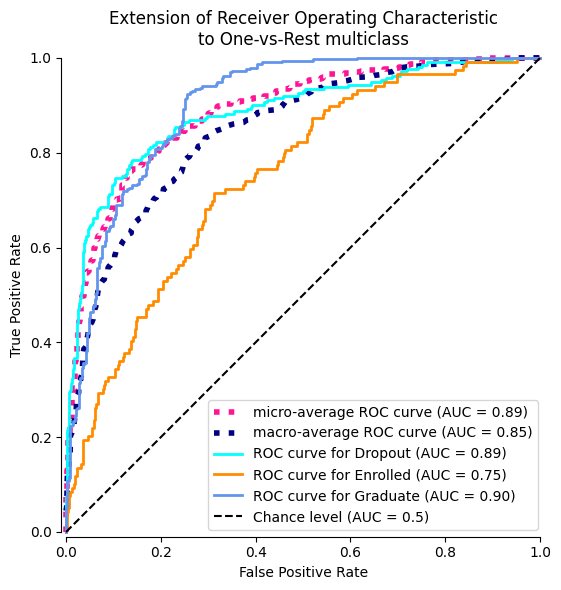

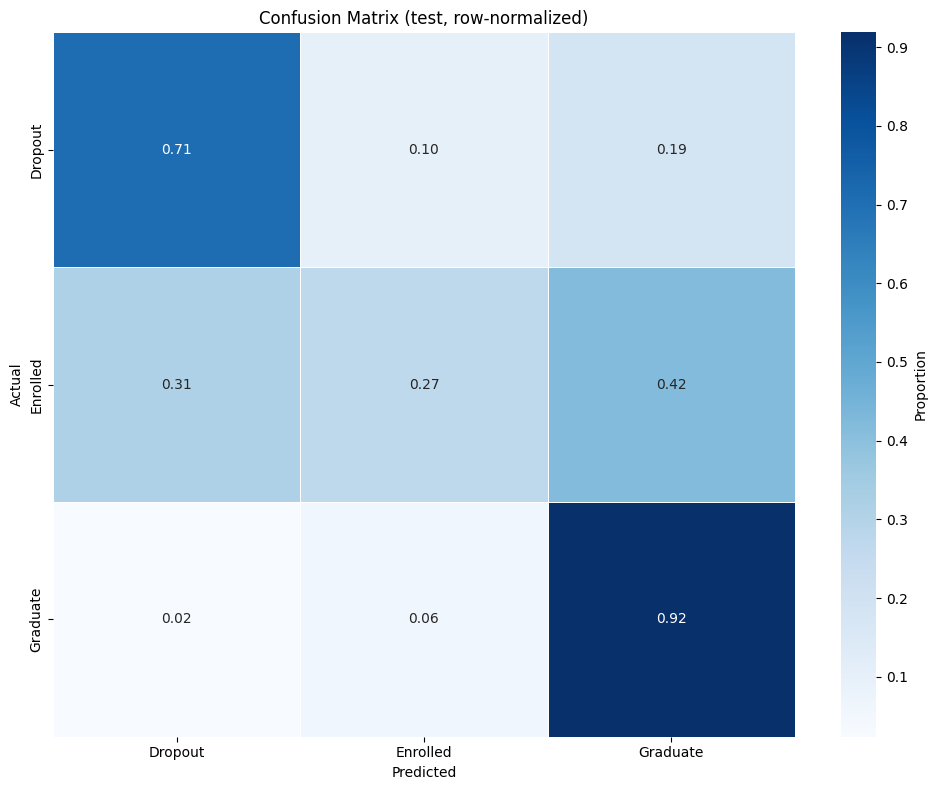

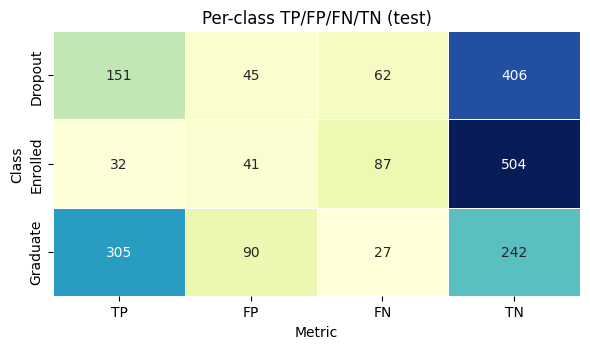

In [294]:
final_model, results = benchmark_classifier(
    LogRegNumpy,
    X_trainval, y_trainval, X_test_scaled, y_test_enc,
    cv_folds=5,
    model_args=model_args,
    fit_args=fit_args,
    class_names=label_encoder.classes_,   # optional
    plot_roc=True,
    plot_confusions=True
)